# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
from numpy import linalg as LA

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [9]:
trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)
        allFaces.append(img)
        labels.append(i)

randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

print(trainFaces.shape)

(360, 112, 92)


In [10]:
flattened_trainFaces = np.vstack([arr.flatten() for arr in trainFaces])
X_train_faces = flattened_trainFaces.transpose()

flattened_testFaces = np.vstack([arr.flatten() for arr in testFaces])
X_test_faces = flattened_testFaces.transpose()
# print(X_test_faces.shape)

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [11]:
def principalComponentAnalysis(X, numComponents):

    numImages, imgHeight, imgWidth = X.shape
    X_flat = X.reshape(numImages, -1)
    meanFace = np.mean(X_flat, axis=0)
    X_centered = X_flat - meanFace
    covariance_matrix = np.dot(X_centered.T, X_centered) / numImages
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    eigenfaces = eigenvectors[:, :numComponents]

    return eigenfaces, meanFace

eigenFaces, meanFace = principalComponentAnalysis(trainFaces, 10)

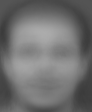

In [27]:
# plot the eigen faces
from google.colab.patches import cv2_imshow
%matplotlib inline

meanFace_plot = meanFace.reshape((112, 92))
cv2_imshow(meanFace_plot)

In [14]:
!pip install opencv-python

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [20]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    numImages, imgHeight, imgWidth = testFace.shape
    testFace_flat = testFace.reshape(numImages, -1)
    testFace_centered = testFace_flat - meanFace
    weights = np.dot(testFace_centered, eigenFaces)
    reconstructed_face = meanFace + np.dot(weights, eigenFaces.T)

    return reconstructed_face.reshape(testFace.shape)

img = imageReconstruction(testFaces, eigenFaces, meanFace)

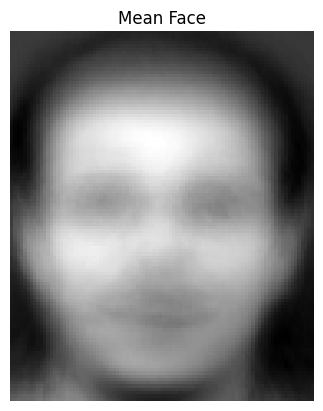

In [24]:
# plot recontructions here
%matplotlib inline

plt.imshow(meanFace.reshape(trainFaces[0].shape), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

ValueError: not enough values to unpack (expected 3, got 2)

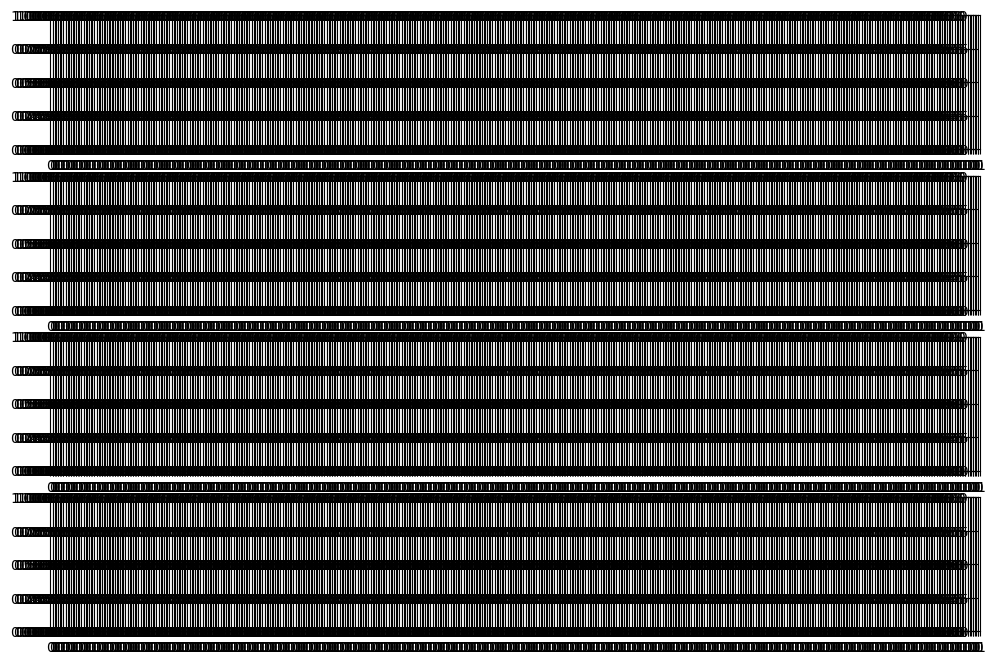

In [25]:
%matplotlib inline

def displayNfactors(trainFaces, eigenfaces, meanFace):
    num_factors=[5, 10, 50, 100]
    num_rows = len(num_factors)
    num_cols = len(trainFaces)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, num in enumerate(num_factors):
        for j, face in enumerate(trainFaces):
            reconstructed_face = imageReconstruction(face, eigenfaces[:, :num], meanFace)
            axes[i, j].imshow(cv2.cvtColor(reconstructed_face, cv2.COLOR_BGR2RGB), cmap='gray')
            axes[i, j].set_title(f'PC={num}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

displayNfactors(trainFaces, eigenFaces, meanFace)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

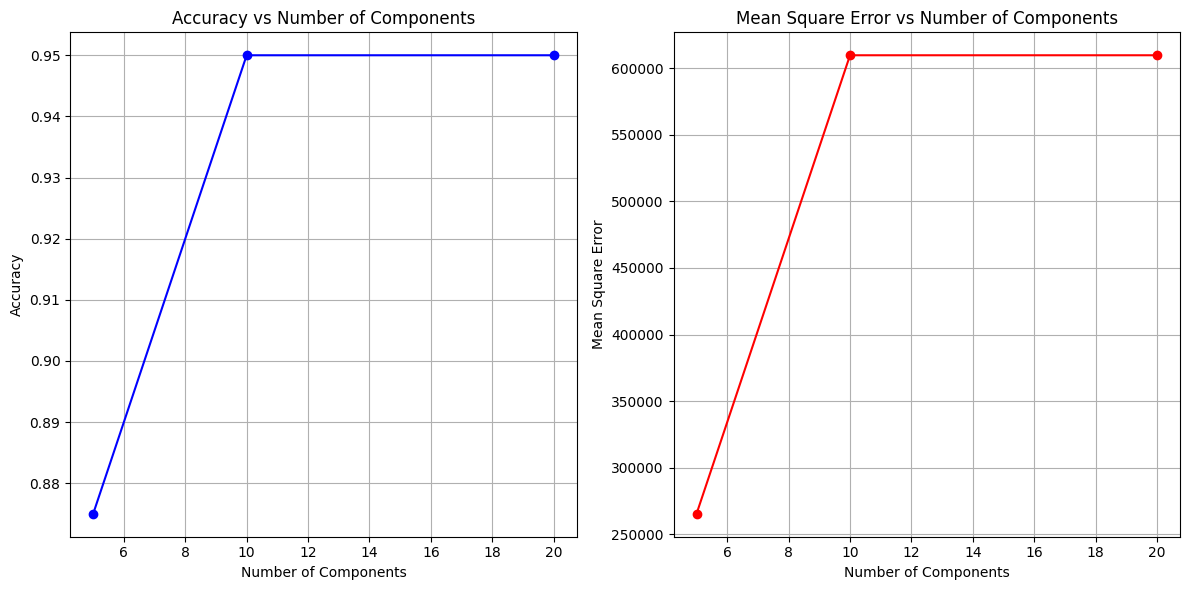

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

def getClass(test_image, eigenVectors, meanEigenFace, X_train, y_train):

    min_error = float('inf')
    prediction = None
    best_image = None
    test_image_flat = test_image.reshape(-1)

    meanEigenFace = meanEigenFace.reshape(10304)
    test_image_centered = test_image_flat - meanEigenFace
    weights = np.dot(test_image_centered, eigenVectors)

    for i, train_image in enumerate(X_train):
        train_image_flat = train_image.reshape(-1)
        train_image_centered = train_image_flat - meanEigenFace

        # Project training image onto eigenfaces
        train_weights = np.dot(train_image_centered, eigenVectors)

        # Compute Euclidean distance between test and training image
        error = np.linalg.norm(weights - train_weights)

        # Update minimum error and prediction
        if error < min_error:
            min_error = error
            prediction = y_train[i]
            best_image = train_image

    return best_image, min_error, prediction

def testFaceRecognition(X_train, y_train, X_test, y_test, eigenVectors, meanEigenFace, num_components_range):
    accuracies = []
    errors = []

    for num_components in num_components_range:
        correct = 0
        total = 0
        mse_sum = 0

        for i, test_image in enumerate(X_test):
            best_image, min_error, prediction = getClass(test_image, eigenVectors[:, :num_components], meanEigenFace, X_train, y_train)
            mse_sum += min_error ** 2

            if prediction == y_test[i]:
                correct += 1
            total += 1

        accuracy = correct / total
        mse = mse_sum / total

        accuracies.append(accuracy)
        errors.append(mse)

    return accuracies, errors

def plotResults(num_components_range, accuracies, errors):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(num_components_range, accuracies, marker='o', color='b')
    plt.title('Accuracy vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(num_components_range, errors, marker='o', color='r')
    plt.title('Mean Square Error vs Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Square Error')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

num_components_range = [5, 10, 20]
accuracies, errors = testFaceRecognition(trainFaces, trainLabels, testFaces, testLabels, eigenFaces, meanFace, num_components_range)
plotResults(num_components_range, accuracies, errors)


Iterate through all the images in the test data and test the accuracy by taking different number of components

In [ ]:
components = [3,5,10,20,30,40,50]
mse = []

for numComponents in components:
    # your code here

Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# your code here

Plot Number of eigenvectors vs Logarithmic Mean Square Error

In [ ]:
# your code here